In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, AveragePooling2D
from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
%matplotlib inline
import json, datetime

In [2]:
#Dataset path
train_dir = '../../Dataset/igneous rocks/train'
val_dir = '../../Dataset/igneous rocks/test'

In [3]:
# hyperparameters
img_width, img_height = 299, 299
batch_size = 16
epochs = 20

In [4]:
# Data augmentation and preprocessing for the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,  
    vertical_flip=True  
    )
val_datagen = ImageDataGenerator(rescale=1./255,
                                 )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2256 images belonging to 27 classes.
Found 2256 images belonging to 27 classes.


In [5]:
class_labels = train_generator.class_indices
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(class_labels)
print(num_classes)
print(class_names)

{'Anorthosite': 0, 'Aplite': 1, 'Basalt': 2, 'Dacite': 3, 'Dolerite': 4, 'Dunite': 5, 'Essexite': 6, 'Granodiorite': 7, 'Komatiite': 8, 'Pegmatite': 9, 'Phonolite': 10, 'Rhyolite': 11, 'Trachyte': 12, 'Tuff': 13, 'andesite': 14, 'diorite': 15, 'gabbro': 16, 'granite': 17, 'ignimbrite': 18, 'norite': 19, 'obsidian': 20, 'olivine basalt': 21, 'pillow': 22, 'pumice': 23, 'syenite': 24, 'tephrite': 25, 'volcanic bombs': 26}
27
['Anorthosite', 'Aplite', 'Basalt', 'Dacite', 'Dolerite', 'Dunite', 'Essexite', 'Granodiorite', 'Komatiite', 'Pegmatite', 'Phonolite', 'Rhyolite', 'Trachyte', 'Tuff', 'andesite', 'diorite', 'gabbro', 'granite', 'ignimbrite', 'norite', 'obsidian', 'olivine basalt', 'pillow', 'pumice', 'syenite', 'tephrite', 'volcanic bombs']


In [6]:
#Model
xcep_model = Xception(weights='imagenet', include_top=False)
x = xcep_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(num_classes,activation='softmax')(x)
model = Model(inputs=xcep_model.input, outputs=predictions)

In [7]:
for layer in xcep_model.layers:
    layer.trainable = False

In [8]:
# Model compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1, 
                               mode='auto')

In [10]:
now = datetime.datetime.now
t = now()
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping])

Epoch 1/20


2023-06-23 20:59:35.973319: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


141/141 [==============================] - 140s 986ms/step - loss: 2.9165 - accuracy: 0.2119 - val_loss: 2.5406 - val_accuracy: 0.2717
Epoch 2/20
141/141 [==============================] - 158s 1s/step - loss: 2.4619 - accuracy: 0.3063 - val_loss: 2.2643 - val_accuracy: 0.3289
Epoch 3/20
141/141 [==============================] - 162s 1s/step - loss: 2.3550 - accuracy: 0.3471 - val_loss: 2.1426 - val_accuracy: 0.3777
Epoch 4/20
141/141 [==============================] - 166s 1s/step - loss: 2.2199 - accuracy: 0.3652 - val_loss: 1.9577 - val_accuracy: 0.4246
Epoch 5/20
141/141 [==============================] - 166s 1s/step - loss: 2.0965 - accuracy: 0.3972 - val_loss: 1.9879 - val_accuracy: 0.3994
Epoch 6/20
141/141 [==============================] - 166s 1s/step - loss: 2.1071 - accuracy: 0.4051 - val_loss: 1.7274 - val_accuracy: 0.4747
Epoch 7/20
141/141 [==============================] - 171s 1s/step - loss: 2.1217 - accuracy: 0.4065 - val_loss: 1.8177 - val_accuracy: 0.4707
Epoch 8

In [11]:
print('Training time: %s' % (now() - t))

Training time: 0:56:43.211859


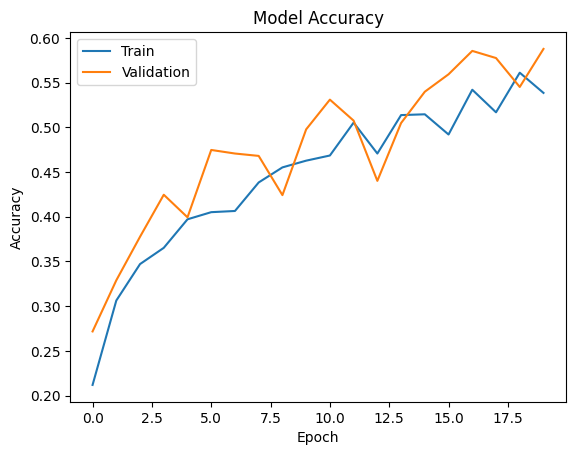

In [12]:
# Visualize training and validation accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

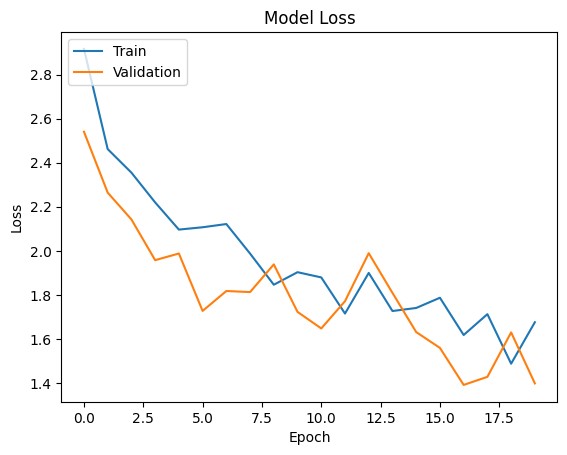

In [13]:
#Visualize training and validation loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print('Accuracy Loss:', val_loss)
print('Accuracy Rating:', val_accuracy)

141/141 [==============================] - 87s 618ms/step - loss: 1.3984 - accuracy: 0.5878
Accuracy Loss: 1.3983919620513916
Accuracy Rating: 0.5877659916877747


In [15]:
# Getting predict and actual labels
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_labels = val_generator.classes

141/141 [==============================] - 77s 544ms/step


In [16]:
# Confusion matrixi
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[131   9   3   7   0   0   0   3   0   0   2   5   0   4   1   0   1   1
    0   0   0   0   0   9   4   0   0]
 [  6  62   0   2   0   0   0   1   0   0   2   4   0   0   3   0   0   0
    0   0   0   0   0   4   1   2   2]
 [  7   0  62   3   0   1   0   0   0   0   5   3   0   0   4   0   0   0
    0   0   0   0   0   9   0   0   0]
 [  5   3   1  76   0   2   0   1   0   1   4  15   0   0   3   0   1   0
    1   0   6   0   0  15   2   0   2]
 [  0   2   1   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  9   5   2   5   1  53   0   0   0   0   9  10   0   1   2   0   0   1
    0   0   0   6   0  11   2   1   0]
 [  0   0   1   1   0   0   2   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  3   7   0  12   0   0   0  54   0   0   8   3   0   1   5   0   1   1
    0   0   0   0   0   9   5   0   2]
 [  0   1   0   1   0   0   0   0  14   0   4   2   0   0   2   0   0   0
    

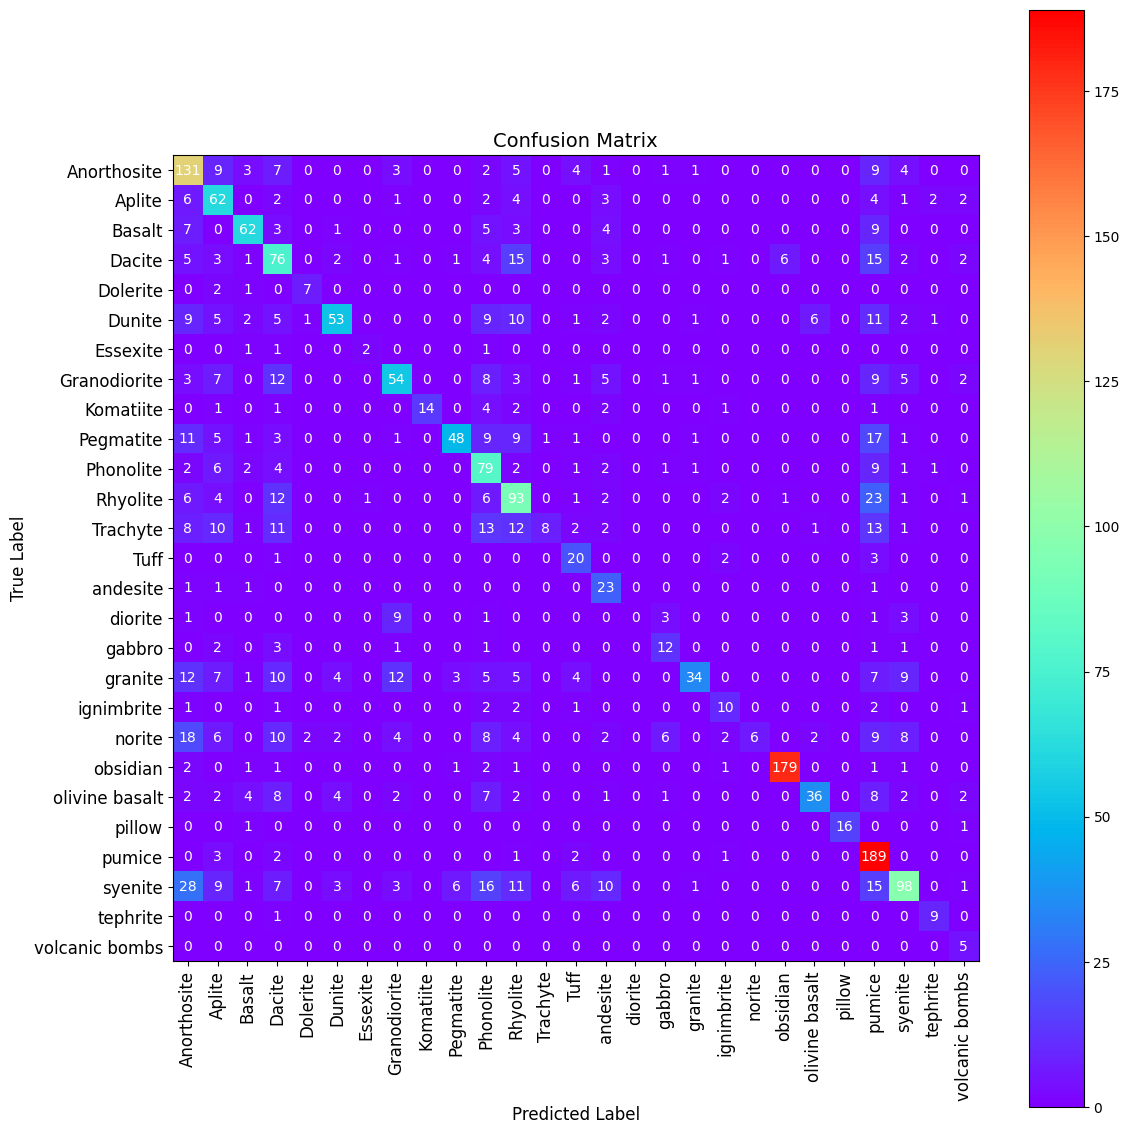

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm, cmap='rainbow')

# Renk çubuğu
cbar = plt.colorbar(im)

# Sınıf etiketleri
class_labels = [f'Class {i+1}' for i in range(num_classes)]
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_names, rotation=90, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Grid çizgileri
ax.grid(visible=False)

# Confusion matrix değerlerinin yazdırılması
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.tight_layout()
plt.show()

In [22]:
class_report = classification_report(true_labels, y_pred, target_names=class_names, zero_division=1)
print('Class Raport:')
print(class_report)

Class Raport:
                precision    recall  f1-score   support

   Anorthosite       0.52      0.73      0.61       180
        Aplite       0.43      0.70      0.53        89
        Basalt       0.75      0.66      0.70        94
        Dacite       0.42      0.55      0.48       138
      Dolerite       0.70      0.70      0.70        10
        Dunite       0.77      0.45      0.57       118
      Essexite       0.67      0.40      0.50         5
  Granodiorite       0.59      0.49      0.53       111
     Komatiite       1.00      0.54      0.70        26
     Pegmatite       0.81      0.44      0.57       108
     Phonolite       0.43      0.71      0.54       111
      Rhyolite       0.51      0.61      0.55       153
      Trachyte       0.89      0.10      0.18        82
          Tuff       0.45      0.77      0.57        26
      andesite       0.37      0.85      0.52        27
       diorite       1.00      0.00      0.00        18
        gabbro       0.46      0.

In [19]:
# Save the model and results
model.save('xception_model.h5')
np.save('confusion_matrix.npy', cm)
with open('classification_report.txt', 'w') as f:
    f.write(class_report)

with open("history.json", "w") as f:
    json.dump(history.history, f)